In [15]:
from geopy.geocoders import Nominatim

def geocoding(address):
    geolocoder = Nominatim(user_agent = 'South Korea', timeout=None)
    geo = geolocoder.geocode(address)
    crd = {"lat": str(geo.latitude), "lng": str(geo.longitude)}

    return crd

crd = geocoding("광주광역시 동구 필문대로 309(서석동,조선대학교)")
lat = float(crd['lat'])
lon = float(crd['lng'])

In [19]:
from _0_Data_download import _0_download_road_network_with_osmnx as omx

road_downloader = omx.OsmnxDownload()
road_downloader.save_img_folder = './tmp/road'
road_downloader.save_map_image(lon, lat)


35.1444133 126.9262935


In [18]:
from _0_Data_download import _1_download_sat_with_folium as fol 

sat_downloader = fol.FoliumCrawl()
sat_downloader.png_path = './tmp/sat'
fol.make_dirs(sat_downloader.png_path)
sat_downloader.screenshot(lat, lon)

In [20]:
from _0_Data_download import _2_download_dem_with_gee as dem

dem_downloader = dem.EEH()
dem_downloader.alos_path = './tmp/dem'
fol.make_dirs(dem_downloader.alos_path)
dem_downloader.getALOSDEM(lat, lon)

Done: ./tmp/dem/35.1444133_126.9262935_dem.png


In [22]:
from PIL import Image
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import tensorflow as tf
import os
model = tf.keras.models.load_model('./three_image(3_label)_MobileNet')

%matplotlib inline 

def get_image(filename):
    satpath = f'tmp/sat/{filename}.png'
    dempath = f'tmp/dem/{filename}_dem.png'
    roadpath = f'tmp/road/{filename}.png'

    if os.path.exists(dempath) and os.path.exists(satpath) and os.path.exists(roadpath):
        sat_image = np.array([tf.keras.utils.img_to_array(Image.open(satpath).convert('RGB').resize((128, 128)))])
        dem_image = np.array([tf.keras.utils.img_to_array(Image.open(dempath).convert('RGB').resize((128, 128)))])
        osm_image = np.array([tf.keras.utils.img_to_array(Image.open(roadpath).convert('RGB').resize((128, 128)))])
        
        sat_image = tf.keras.applications.mobilenet_v2.preprocess_input(sat_image)
        dem_image = tf.keras.applications.mobilenet_v2.preprocess_input(dem_image)
        osm_image = tf.keras.applications.mobilenet_v2.preprocess_input(osm_image)
        
        fig = plt.figure()
        rows = 1
        cols = 3
        ax1 = fig.add_subplot(rows, cols, 1)
        ax1.imshow(cv2.imread(satpath), interpolation='nearest')

        ax2 = fig.add_subplot(rows, cols, 2)
        ax2.imshow(cv2.imread(dempath), interpolation='nearest')

        ax3 = fig.add_subplot(rows, cols, 3)
        ax3.imshow(cv2.imread(roadpath), interpolation='nearest')
        plt.show()
        
        return [sat_image, dem_image, osm_image]
    
    return [None, None, None, None]

def pred_img(lat, lon):
    imgs = get_image(f'{lat}_{lon}')
    if len(imgs) != 3:
        print(0)
    else:
        pred = model.predict(imgs)
        print(pred)
        print('level: ', np.argmax(pred, axis=1)[0])

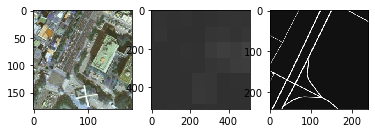

1/1 [==============================] - 5s 5s/step
[[5.0730985e-03 9.9401313e-01 9.1377838e-04]]
level:  1


In [23]:
pred_img(lat, lon)